# Projeto de Teste A/B

### Descrição técnica
- Nome do teste: recommender_system_test
- Grupos: A (controle) e B (funil de novos pagamentos)
- Data de início: 07-12-2020
- Quando paparam de receber novos usuários: 21-12-2020
- Data de término: 01-01-2021
- Público: 15% de novos usuários da região da UE
- Propósito do teste: testar mudanças relacionadas à introdução de um sistema de recomendação melhorado
- Resultado esperado: em até 14 dias após o cadastro, usuários mostram uma conversão melhor nas visualizações de página do produto (o evento product_page event), em adicionar itens ao carrinho (product_cart) e de compras (purchase). Em cada etapa do funil product_page → product_cart → purchase, haverá ao menos 10% de aumento.
- Número esperado de participantes do teste: 6000


#### 1 - Importação de bibliotecas e leitura dos dados 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math as mth
from scipy import stats as st
from statsmodels.stats.proportion import proportions_ztest
import datetime as dt
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore")

sns.set_context('notebook', font_scale=1, rc={"lines.linewidth": 2.5})

In [2]:
mkt_events = pd.read_csv('ab_project_marketing_events_us.csv')
users = pd.read_csv('final_ab_new_users_upd_us.csv')
users_events = pd.read_csv('final_ab_events_upd_us.csv')
ab_participants = pd.read_csv('final_ab_participants_upd_us.csv')

#### 2. Pré análise dos dados

In [3]:
mkt_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [4]:
users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [5]:
users_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [6]:
ab_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


In [7]:
mkt_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [8]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [9]:
users_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [10]:
ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


Interpretação:
* Nome das colunas em formato correto snake_case
* Todas as colunas de datas com formato incorreto, precisa ser convertido para datetime 
* Coluna details em users_events tem grande numero de valores ausentes 

#### 3. Limpeza dos dados

In [11]:
#converting columns date for datetime 
def convert_date(df, cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col], errors='coerce') # 'coerce' evita erro se houver valores inválidos

In [12]:
convert_date(mkt_events, ['start_dt', 'finish_dt'])
convert_date(users, ['first_date'])
convert_date(users_events, ['event_dt'])

In [13]:
#new column in events only with date, no timestamp 
users_events['event_date'] = users_events['event_dt'].dt.date
users_events.head()

,user_id,event_dt,event_name,details,event_date
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,2020-12-07
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,2020-12-07


In [14]:
#missing data 
print(users_events['details'].isna().mean())

print(users_events['event_name'].value_counts())

0.8576697714041641
event_name
login           182465
product_page    120862
purchase         60314
product_cart     60120
Name: count, dtype: int64


Existem 4 tipos de eventos no DF users_events e 85% dos dados estão ausentes na coluna details desse mesmo DF, dado o alto volume de dados ausentes é provável que ausencia esteja relacionada com o tipo de evento. 

In [15]:
print(users_events[(users_events['event_name'] == 'purchase') & (users_events['details'].isna())]) #todo o df filtrado entre [] e logicas booleanas entre() 

Empty DataFrame
Columns: [user_id, event_dt, event_name, details, event_date]
Index: []


In [16]:
print(users_events[(users_events['event_name'].isin(['product_page', 'login', 'product_cart'])) & ~(users_events['details'].isna())]) #isin() para verificar se os valores de uma lista estão presentes em uma coluna e segunda logica dos ausentes depois

Empty DataFrame
Columns: [user_id, event_dt, event_name, details, event_date]
Index: []


Confirmado que a ausencia de valores está relacionada aos eventos, nesse caso como o evento purchase é o único evento com valores presentes e o objetivo da nossa análise não é sobre o valor de compra dos usuários, a coluna será deletada do data frame 

In [17]:
users_events.drop('details', axis=1, inplace=True)

#### 4. EDA e verificação se os dados seguem a descrição técninca 

In [18]:
ab_participants['ab_test'].value_counts()

ab_test
interface_eu_test          10850
recommender_system_test     3675
Name: count, dtype: int64

Em análise do df ab_participants foi verificado que temos cadastros para dois testes diferentes, como o nosso objetivo é somente sobre o teste 'recommender_system_test' optei por fazer um merge entre ab_participants e users_events através do user_id, onde irei filtrar users events somente com os usuários que fazem parte do teste objetivo

In [19]:
df_ab = users_events.merge(ab_participants, on='user_id')

In [20]:
#filtering for recommender_system_test
df_rst = df_ab[df_ab['ab_test']== 'recommender_system_test']
df_rst.head()

,user_id,event_dt,event_name,event_date,group,ab_test
1,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,2020-12-07,A,recommender_system_test
6,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,2020-12-07,A,recommender_system_test
14,49EA242586C87836,2020-12-07 06:31:24,purchase,2020-12-07,B,recommender_system_test
16,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,2020-12-07,A,recommender_system_test
18,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,2020-12-07,B,recommender_system_test


##### Quais e qual frequência de ocorrência dos eventos no registro

In [21]:
#events sequence
df_rst['event_name'].value_counts()

event_name
login           10837
product_page     6702
purchase         3210
product_cart     3160
Name: count, dtype: int64

Aparentemente tem um erro no funil, pois existem mais "purchase events" do que "product_cart" que teoricamente seria uma etapa anterior. Acredito que 
sequência correta de eventos seria: login > product_page > product_cart > purchase 

##### Quantos usuários nos registros

In [22]:
df_rst['user_id'].nunique()

3675

* Pareque o número minimo esperado de participantes para o teste não foi alcançado, o número esperado era de 6000

##### Número médio de eventos por usuário 

In [23]:
n_events_per_user = df_rst.groupby('user_id')['event_name'].count()
print(f'O número médio de eventos por usuário é de {int(n_events_per_user.mean())} eventos')

O número médio de eventos por usuário é de 6 eventos


##### Verificando periodo de eventos que os dados cobrem

In [24]:
print(f'O periodo coberto pelos dados é de {df_rst['event_date'].min()} até {df_rst['event_date'].max()}')

O periodo coberto pelos dados é de 2020-12-07 até 2020-12-30


Como o objetivo do teste é verificar se em até 14 dias após o cadastro, os usuários melhoram a conversão, estarei adicionado ao df_rst a coluna 'first_date' da tabela users, onde obtenho assim a informação de data do registro dos usuários

In [25]:
df_rst = df_rst.merge(users, on='user_id', how='left')

In [26]:
df_rst.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23909 entries, 0 to 23908
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     23909 non-null  object        
 1   event_dt    23909 non-null  datetime64[ns]
 2   event_name  23909 non-null  object        
 3   event_date  23909 non-null  object        
 4   group       23909 non-null  object        
 5   ab_test     23909 non-null  object        
 6   first_date  23909 non-null  datetime64[ns]
 7   region      23909 non-null  object        
 8   device      23909 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 1.6+ MB


In [27]:
print(df_rst['first_date'].max())

2020-12-21 00:00:00


Os dados cobrem o periodo somente até dia 30/12 e o último cadastro de usuário ocorreu no dia 21/12 o que não daria 14 dias de diferença, a data correta de término do teste seria 04/12 onde assim todos os usuários estariam sobre condições iguais de melhora de conversão em até 14 dias, os ultimos usuários aparentemente tiveram menos dias 

##### Como o número de eventos é distribuído entre os dias?

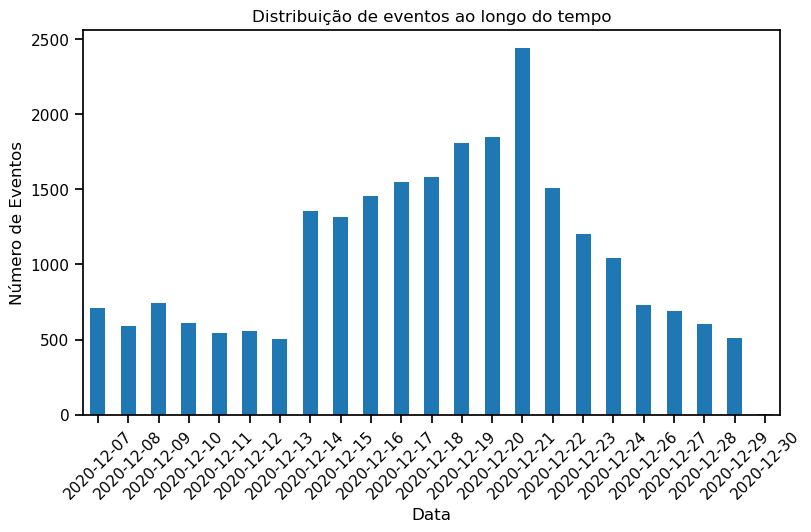

In [28]:
# distribution of events per day
df_rst.groupby('event_date').size().plot(kind='bar', figsize=(9, 5))

plt.xlabel("Data")
plt.ylabel("Número de Eventos")
plt.title("Distribuição de eventos ao longo do tempo")
plt.xticks(rotation=45)
plt.show()

Os dados não parecem estar igualmente completos

##### Qual período os dados realmente representam?

In [29]:
events_count = df_rst.groupby('event_date').size()
events_count

event_date
2020-12-07     709
2020-12-08     593
2020-12-09     746
2020-12-10     613
2020-12-11     542
2020-12-12     558
2020-12-13     504
2020-12-14    1355
2020-12-15    1316
2020-12-16    1454
2020-12-17    1548
2020-12-18    1584
2020-12-19    1810
2020-12-20    1848
2020-12-21    2441
2020-12-22    1506
2020-12-23    1201
2020-12-24    1042
2020-12-26     733
2020-12-27     691
2020-12-28     603
2020-12-29     508
2020-12-30       4
dtype: int64

Há dias com com poucos eventos, o que pode indicar um problema na coleta de dados. O teste foi feito perto do período de feriados (natal e ano novo) o que pode ter ajudado na distribuição desigual e prejudica os resultados do teste Z. Para não haver distorção no quadro geral irei fazer um corte nos dados, mantendo somente a partir do momento que os dados parecem estar igualmente completos, a principio irei cortar os dias onde os dados estão 50% abaixo da média 

In [30]:
# threshold to cut where data is stable
# Below 50% of the average data is considered imcompleted
threshold = events_count.mean() * 0.5

# Find first date where data meet threshold
stable_start = events_count[events_count >= threshold].index.min()
# Find last date where data meet threshold
stable_end = events_count[events_count >= threshold].index.max()

print(f"Os dados começam a ser completos a partir de: {stable_start} até o dia {stable_end}, e esse seria o período válido para um z-test")

Os dados começam a ser completos a partir de: 2020-12-07 até o dia 2020-12-28, e esse seria o período válido para um z-test


In [31]:
# valid period for analysis
df_rst_valid = df_rst[(df_rst['event_date'] >= stable_start) & (df_rst['event_date'] <= stable_end)]

# new date interval
real_min_date = df_rst_valid['event_date'].min()
real_max_date = df_rst_valid['event_date'].max()

print(
    f'O período agora representado pelos dados é de {real_min_date} até {real_max_date}')

O período agora representado pelos dados é de 2020-12-07 até 2020-12-28


##### Quantos eventos e usuários foram perdidos no corte dos dados inválidos?

In [45]:
#data lost
total_rows_before = len(df_rst)
total_rows_after = len (df_rst_valid)

lost_data = total_rows_before - total_rows_after
percent_lost = (lost_data/total_rows_before) * 100 

print(f'Foram perdidos {lost_data} eventos ao fazer o corte de dados inválidos, isso representa {percent_lost:.1f}% dos dados')

Foram perdidos 512 eventos ao fazer o corte de dados inválidos, isso representa 2.1% dos dados


##### Checando grupos de ambas as amostras, distribuição

In [33]:
# groupby per day with groups counts
df_rst_valid.groupby(['event_date', 'group'])['group'].count()

event_date  group
2020-12-07  A         331
            B         378
2020-12-08  A         341
            B         252
2020-12-09  A         385
            B         361
2020-12-10  A         350
            B         263
2020-12-11  A         374
            B         168
2020-12-12  A         355
            B         203
2020-12-13  A         328
            B         176
2020-12-14  A        1083
            B         272
2020-12-15  A        1084
            B         232
2020-12-16  A        1069
            B         385
2020-12-17  A        1252
            B         296
2020-12-18  A        1312
            B         272
2020-12-19  A        1506
            B         304
2020-12-20  A        1528
            B         320
2020-12-21  A        2011
            B         430
2020-12-22  A        1311
            B         195
2020-12-23  A        1005
            B         196
2020-12-24  A         888
            B         154
2020-12-26  A         608
            B       

Há dias que usuários do grupo A estão muito maiores que usuários do grupo B 

In [34]:
df_rst_valid.groupby('group')['group'].count()

group
A    18196
B     5201
Name: group, dtype: int64

* Foi verificado e os grupos não estão igualmente distribuidos 

#### Estudando a conversão em diferentes etapas do funil

##### Proporção de usuários que executaram cada uma das ações

In [35]:
# number of unique user per event
users_per_event = df_rst_valid.groupby('event_name')['user_id'].nunique().reset_index()

# rename columns and sort
users_per_event.columns = ['event_name', 'unique_users']
users_per_event.sort_values('unique_users', ascending=False, inplace=True)

# proportion of users each event
total_users = df_rst_valid['user_id'].nunique()

users_per_event['proportion'] = users_per_event['unique_users'] / total_users
users_per_event

,event_name,unique_users,proportion
0,login,3674,0.999728
2,product_page,2303,0.626667
3,purchase,1128,0.306939
1,product_cart,1079,0.293605


##### Funil de eventos 

In [36]:
# funnel plot
fig = go.Figure(go.Funnel(
    y=users_per_event["event_name"],
    x=users_per_event["unique_users"],
    textinfo="value+percent initial"  # absolute values and initial percentage
))

fig.show()

##### Qual fase perde mais usuários?

In [44]:
# Absolute and percentage of drop off
# diff between next phase periods default 1 (previous row), -1 is next row, axis= Take difference over rows (0 default) or columns (1).
users_per_event["drop_off"] = users_per_event["unique_users"].diff(periods=-1).abs()
users_per_event['drop_off_percentage'] = (users_per_event['drop_off'] / users_per_event['unique_users']) * 100

# find max lost
# saving index with max drop off
max_drop_idx = users_per_event['drop_off'].idxmax()
max_drop_event = users_per_event.loc[max_drop_idx, 'event_name']
max_drop_value = users_per_event.loc[max_drop_idx, 'drop_off']
max_drop_percentage = users_per_event.loc[max_drop_idx, 'drop_off_percentage']

print(f'A maior perda ocorre no {max_drop_event}, onde {max_drop_value:.0f} dos usuários são perdidos, isso representa {max_drop_percentage:.2f}%')

# idmax()Return index of first occurrence of maximum over requested axis.

A maior perda ocorre no login, onde 1371 dos usuários são perdidos, isso representa 37.32%


##### Qual é a parcela de usuários que faz o caminho inteiro, desde o primeiro evento até o pagamento?


In [38]:
# Conversion rate
total_conversion_rate = (users_per_event["unique_users"].iloc[-1] / users_per_event["unique_users"].iloc[0]) * 100 #last row / first row *100

print(f"Apenas {total_conversion_rate:.2f}% dos usuários completam o funil inteiro.")

Apenas 29.37% dos usuários completam o funil inteiro.


##### Particularidades nos dados que você deve considerar antes de começar o teste A/B

* O número de participantes no teste está abaixo do esperado (6000), só existem 3675 usuários únicos
* O teste foi encerrado antes do periodo de 14 dias após o ultimo cadastro de usuário 
* Os grupos A e B não estão igualmente distribuidos 
* A coleta de dados foi feita durante época festiva com feriados (Natal e Ano Novo), resultado pode ser afetado por isso 
* O funil de eventos está incorreto, há alguma falha no sistema, existem mais compras finalizadas do que produtos no carrinho

#### Avaliando os resultados do teste A/B:

* Hipótese nula: Não há diferença estatisticamente significativa em relação a taxa de conversão 
* Hipótese alternativa: Há diferença estatisticamente significativa em relação a taxa de conversão 

##### Eventos mais populares por grupo 

In [57]:
popular_events = df_rst_valid.groupby(['event_name', 'group'])['user_id'].count().unstack().sort_values(by='A', ascending=False)

total_A = popular_events['A'].sum()
total_B = popular_events['B'].sum()

# proportions
popular_events['proportion_A'] = popular_events['A'] / total_A
popular_events['proportion_B'] = popular_events['B'] / total_B

popular_events


group,A,B,proportion_A,proportion_B
event_name,,,,
login,8072,2524,0.443614,0.485291
product_page,5196,1353,0.285557,0.260142
purchase,2501,653,0.137448,0.125553
product_cart,2427,671,0.133381,0.129014


A principio não há grande diferença na proporção de eventos entre os grupos A e B

##### Diferenças estatisticamente significativas na taxa de conversão entre os grupos para diferentes eventos finais (Função) Z-Test

In [58]:
# Function to compare convertion diference between inital event and final different events (stats)
def event_comparison(df, event1, event2, group1, group2, alpha_value=.05):
    # count
    users_start = df[df["event_name"] == event1].groupby("group")["user_id"].nunique()
    users_complete = df[df["event_name"] == event2].groupby("group")["user_id"].nunique()

    # defining values z test
    # initial users .sum() in case want to sum 2 or more groups
    s_group1, s_group2 = users_start[group1].sum(), users_start[group2].sum()
    c_group1, c_group2 = users_complete[group1].sum(), users_complete[group2].sum()  # final users

    # Values to array to apply z test
    count = np.array([c_group1, c_group2])  # Convertion in the groups
    nobs = np.array([s_group1, s_group2])    # Total users in groups

    stat, p_value = proportions_ztest(count, nobs)

    print(f"Estatística do Teste Z: {stat:.4f}, alpha: {alpha_value:.4f}")
    print(f"P-Valor: {p_value:.4f}")

    # results
    if p_value < alpha_value:
        print(
            f"Há diferença estatisticamente significativa em relação a taxa de conversão do evento {event1} para o evento {event2} entre os grupos {group1} e {group2}.")
    else:
        print(
            f"Não há diferença estatisticamente significativa em relação a taxa de conversão do evento {event1} para o evento {event2} entre os grupos {group1} e {group2}.")

In [63]:
event_comparison(df_rst_valid, 'login', 'product_page', 'A', 'B')
event_comparison(df_rst_valid, 'product_page','product_cart', 'A', 'B')
event_comparison(df_rst_valid, 'product_cart','purchase','A', 'B')

Estatística do Teste Z: 4.5613, alpha: 0.0500
P-Valor: 0.0000
Há diferença estatisticamente significativa em relação a taxa de conversão do evento login para o evento product_page entre os grupos A e B.
Estatística do Teste Z: -0.9932, alpha: 0.0500
P-Valor: 0.3206
Não há diferença estatisticamente significativa em relação a taxa de conversão do evento product_page para o evento product_cart entre os grupos A e B.
Estatística do Teste Z: nan, alpha: 0.0500
P-Valor: nan
Não há diferença estatisticamente significativa em relação a taxa de conversão do evento product_cart para o evento purchase entre os grupos A e B.


#### Conclusões sobre a etapa da AED e do resultado do teste A/B.

* Segundo o Z-Test a hipotese alternativa de que há difença estatisticamente significativa na taxa de conversão somente ocorre na etapa entre login > product_page, porém não chega a 10% de aumento como esperado na descrição técnica. 

Muitos princípios da descrição e premissas para um teste A/B não foram seguidos como:
* O número de participantes no teste está abaixo do esperado (6000), só existem 3675 usuários únicos
* O teste foi encerrado antes do periodo de 14 dias após o ultimo cadastro de usuário 
* Os grupos A e B não estão igualmente distribuidos 
* A coleta de dados foi feita durante época festiva com feriados (Natal e Ano Novo), resultado pode ser afetado por isso 
* O funil de eventos está incorreto, há alguma falha no sistema, existem mais compras finalizadas do que produtos no carrinho

Portanto os resultados desse teste A/B não seriam válidos 